In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from arch import arch_model
import math

In [2]:
df=pd.read_csv(r"C:\Users\Bogdan\OneDrive - University of Warwick\Desktop\Projects\Short-Term WTI Price Forecasting\Price prediction\Data.csv")
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
df['WTI'] = pd.to_numeric(df['WTI'])
df = df.sort_values(by='DATE', ascending=True)
df = df.set_index('DATE')
df = df.drop(columns=['Dubai','UK','Dubai Price', 'Texas', 'Brent'])
df = df.asfreq(pd.infer_freq(df.index))
df = df.resample('W').mean()
df['Log_Returns'] = np.log(df['WTI'] / df['WTI'].shift(1)) # r = ln(Pt/Pt-1)
df['Std_Dev'] = df['Log_Returns'].expanding().std() #expanding() = allows you to apply a statistical function cumulatively from the start of a dataset up to each point in the dataset
df = df.dropna()
df

,WTI,Log_Returns,Std_Dev
DATE,,,
2020-07-26,41.3380,0.018753,0.010729
2020-08-02,40.6860,-0.015898,0.017370
2020-08-09,41.1600,0.011583,0.014947
2020-08-16,42.0760,0.022011,0.015128
2020-08-23,42.7260,0.015330,0.013857
...,...,...,...
2024-08-11,75.8450,-0.016489,0.040102
2024-08-18,78.9975,0.040724,0.040090
2024-08-25,74.6780,-0.056231,0.040205


In [3]:
oil_predictions = {'DATE': ['2024-09-15', '2024-09-22', '2024-09-29', '2024-10-06', '2024-10-13', '2024-10-20'], 'Oil Predictions': ['70.876005', '69.530932', '69.679060', '70.731818', '70.735345', '69.941906']}
oil_df = pd.DataFrame(oil_predictions)
oil_df['DATE'] = pd.to_datetime(oil_df['DATE'])
oil_df = oil_df.set_index('DATE')
oil_df['Oil Predictions'] = pd.to_numeric(oil_df['Oil Predictions'])
last_value = df['WTI'].iloc[-1]
data = {'DATE': ['2024-09-08'], 'Oil Predictions': [last_value]}
the_stuff_to_add = pd.DataFrame(data)
the_stuff_to_add['DATE'] = pd.to_datetime(the_stuff_to_add['DATE'])
the_stuff_to_add = the_stuff_to_add.set_index('DATE')
oil_df = pd.concat([the_stuff_to_add, oil_df])
oil_df['Log_Returns'] = np.log(oil_df['Oil Predictions'] / oil_df['Oil Predictions'].shift(1))
save_oil_df = oil_df #for the very last step
oil_df = oil_df.dropna()
oil_df

,Oil Predictions,Log_Returns
DATE,,
2024-09-15,70.876005,-0.005684
2024-09-22,69.530932,-0.019160
2024-09-29,69.679060,0.002128
2024-10-06,70.731818,0.014996
2024-10-13,70.735345,0.000050
2024-10-20,69.941906,-0.011280


In [4]:
train_data = df['Log_Returns']
future_dates = pd.date_range(start=df.index[-1] + timedelta(weeks=1), periods=6, freq='W')
rolling_predictions = pd.Series(index=future_dates)

for i in rolling_predictions.index:
    model = arch_model(train_data, p = 1, q = 1)
    model_fit = model.fit()
    predictions = model_fit.forecast(horizon=1)
    rolling_predictions.loc[i] = np.sqrt(predictions.variance.values[-1]) #the output of predictions is an array that's why the .variance....
    train_data.loc[i] = oil_df.loc[i]['Log_Returns']

rolling_predictions

Iteration:      1,   Func. Count:      6,   Neg. LLF: 9812.381739629122
Iteration:      2,   Func. Count:     16,   Neg. LLF: 266.42145454404044
Iteration:      3,   Func. Count:     26,   Neg. LLF: -376.16243908432466
Iteration:      4,   Func. Count:     32,   Neg. LLF: -378.36573251146274
Iteration:      5,   Func. Count:     38,   Neg. LLF: -379.3695790945678
Iteration:      6,   Func. Count:     44,   Neg. LLF: -373.5574697261627
Iteration:      7,   Func. Count:     50,   Neg. LLF: -380.38824857346907
Iteration:      8,   Func. Count:     56,   Neg. LLF: -381.4947917308391
Iteration:      9,   Func. Count:     62,   Neg. LLF: -385.099850952887
Iteration:     10,   Func. Count:     68,   Neg. LLF: -385.2587570157659
Iteration:     11,   Func. Count:     73,   Neg. LLF: -385.26026891656215
Iteration:     12,   Func. Count:     78,   Neg. LLF: -385.2602773999846
Iteration:     13,   Func. Count:     84,   Neg. LLF: -385.2602934941666
Iteration:     14,   Func. Count:     90,   Neg. 

c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001622. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001615. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataS

2024-09-15    0.038522
2024-09-22    0.037765
2024-09-29    0.037312
2024-10-06    0.037399
2024-10-13    0.036019
2024-10-20    0.036510
Freq: W-SUN, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([<matplotlib.axis.XTick at 0x248efef7e90>,
 [Text(19981.0, 0, '2024-09-15'),
  Text(19988.0, 0, '2024-09-22'),
  Text(19995.0, 0, '2024-09-29'),
  Text(20002.0, 0, '2024-10-06'),
  Text(20009.0, 0, '2024-10-13'),
  Text(20016.0, 0, '2024-10-20')])

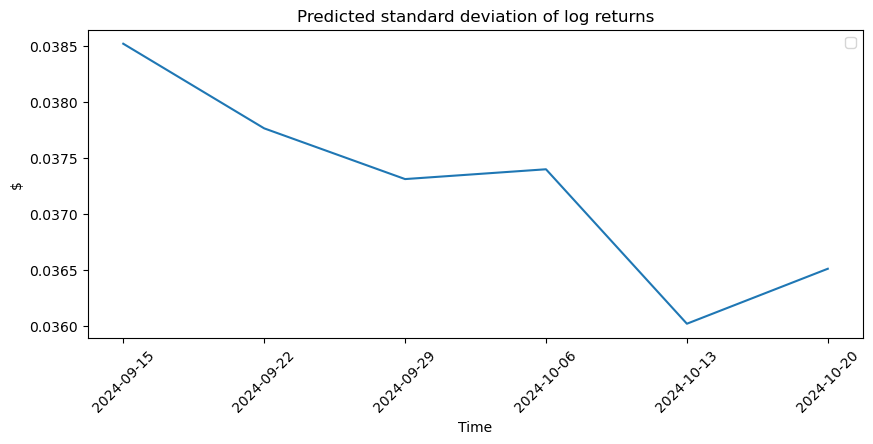

In [5]:
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions)
plt.title('Predicted standard deviation of log returns')
plt.ylabel('$')
plt.xlabel('Time')
plt.legend()
plt.xticks(rolling_predictions.index, rotation=45)

In [6]:
save_oil_df

,Oil Predictions,Log_Returns
DATE,,
2024-09-08,71.280000,NaN
2024-09-15,70.876005,-0.005684
2024-09-22,69.530932,-0.019160
2024-09-29,69.679060,0.002128
2024-10-06,70.731818,0.014996
2024-10-13,70.735345,0.000050
2024-10-20,69.941906,-0.011280


In [7]:
rolling_predictions

2024-09-15    0.038522
2024-09-22    0.037765
2024-09-29    0.037312
2024-10-06    0.037399
2024-10-13    0.036019
2024-10-20    0.036510
Freq: W-SUN, dtype: float64

In [8]:
WTI_price_std = []
for i in range (0,6):
    WTI_price_variance = save_oil_df['Oil Predictions'][i]**2 * math.e**((1/52)*rolling_predictions[i]) * (math.e**((1/52)*rolling_predictions[i]) - 1) #I inserted screenshots below to explain why this equation
    WTI_price_std.append(np.sqrt(WTI_price_variance))

WTI_price_std = np.array(WTI_price_std)

new_df = pd.DataFrame(WTI_price_std, index=rolling_predictions.index, columns=['WTI price std'])
new_df

C:\Users\Bogdan\AppData\Local\Temp\ipykernel_4072\3679015877.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  WTI_price_variance = save_oil_df['Oil Predictions'][i]**2 * math.e**((1/52)*rolling_predictions[i]) * (math.e**((1/52)*rolling_predictions[i]) - 1) #I inserted screenshots below to explain why this equation


,WTI price std
2024-09-15,1.941149
2024-09-22,1.911082
2024-09-29,1.863511
2024-10-06,1.869676
2024-10-13,1.862525
2024-10-20,1.875293


![Screenshot of Analysis](Screenshot_847.png)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([<matplotlib.axis.XTick at 0x248effa9ad0>,
 [Text(19981.0, 0, '2024-09-15'),
  Text(19988.0, 0, '2024-09-22'),
  Text(19995.0, 0, '2024-09-29'),
  Text(20002.0, 0, '2024-10-06'),
  Text(20009.0, 0, '2024-10-13'),
  Text(20016.0, 0, '2024-10-20')])

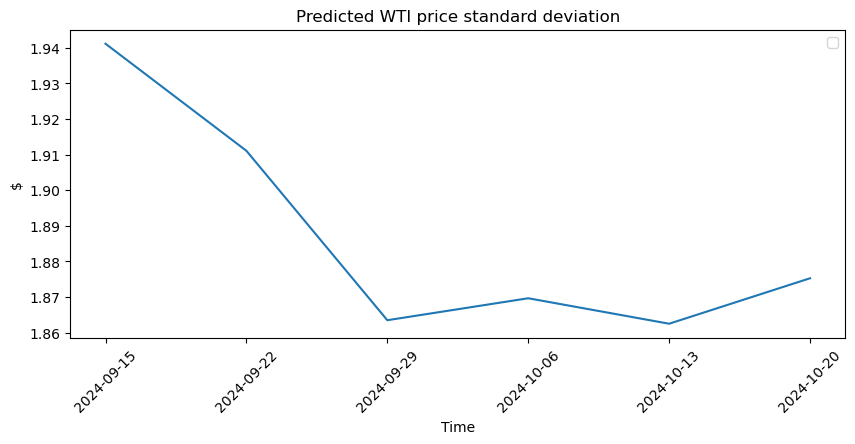

In [9]:
plt.figure(figsize = (10,4))
plt.plot(new_df)
plt.title('Predicted WTI price standard deviation')
plt.ylabel('$')
plt.xlabel('Time')
plt.legend()
plt.xticks(new_df.index, rotation=45)